In [1]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio 
!pip install timm
!pip install optuna scikit-learn matplotlib seaborn tqdm albumentations


In [2]:
# imports básicos e configuração de seed para reprodutibilidade
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # biblioteca com EfficientNet
import optuna  # busca de hiperparâmetros
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- REPRODUTIBILIDADE ---
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False

# --- Paths do dataset ---
TRAIN_DIR = "small-aid/training"
TEST_DIR  = "small-aid/test"

# --- dispositivo ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


/home/queimadas/Desktop/mestrado/deep_learning/EfficientNet/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [3]:
# adicão do canal NGRDI = (G - R) / (G + R)
# Observação: usamos mean/std ImageNet para R,G,B e mean=0,std=1 para NGRDI.

import torch

IMAGENET_MEAN = [0.485, 0.456, 0.406]  # R G B
IMAGENET_STD  = [0.229, 0.224, 0.225]  # R G B

# adicionamos média e std para o 4º canal (NGRDI)
MEAN_4CH = IMAGENET_MEAN + [0.0]   # assumimos média 0 para NGRDI (padrão)
STD_4CH  = IMAGENET_STD  + [1.0]   # assumimos desvio 1 para NGRDI (padrão)

IMG_SIZE = 300

# função utilitária para computar NGRDI a partir de um tensor CxHxW
def add_ngrdi_channel(tensor):
    """
    tensor: torch.Tensor shape (3, H, W) com canais R,G,B no intervalo [0,1] (após ToTensor)
    retorna: tensor (4, H, W) com R,G,B e canal NGRDI = (G - R) / (G + R + eps)
    """
    eps = 1e-6
    r = tensor[0]
    g = tensor[1]
    ngrdi = (g - r) / (g + r + eps)
    ngrdi = ngrdi.unsqueeze(0)
    return torch.cat([tensor, ngrdi], dim=0)

# Transform de treino: aplicamos augmentations sobre PIL, depois ToTensor, depois adicionamos NGRDI, depois Normalize 4 canais
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),            # agora tensor 3xHxW com valores em [0,1]
    transforms.Lambda(lambda t: add_ngrdi_channel(t)),  # adiciona 4º canal
    transforms.Normalize(MEAN_4CH, STD_4CH)
])

# Transform de teste/validação
test_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.1)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: add_ngrdi_channel(t)),
    transforms.Normalize(MEAN_4CH, STD_4CH)
])


In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# recria datasets com os novos transforms (agora retornam 4 canais)
train_dataset = ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = ImageFolder(TEST_DIR,  transform=test_transform)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
print("Número de classes:", num_classes)
print("Tamanho train:", len(train_dataset), "tamanho test:", len(test_dataset))

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Classes: ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
Número de classes: 30
Tamanho train: 3600 tamanho test: 2400


In [5]:
# função que cria o modelo EfficientNet com suporte a in_chans=4

def create_model(model_name="tf_efficientnet_b3", num_classes=num_classes, pretrained=True, in_chans=4):
    """
    model_name: nome do modelo timm
    num_classes: número de classes de saída
    pretrained: True/False
    in_chans: número de canais de entrada (colocamos 4 para R,G,B,NGRDI)
    """
    # timm aceita in_chans; quando pretrained=True, timm adapta o primeiro conv se necessário.
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, in_chans=in_chans)

    # Congela todas as camadas por padrão e libera o head/classifier para fine-tuning (mesma estratégia do modelo do exercicio 1)
    for param in model.parameters():
        param.requires_grad = False

    # tenta obter o classificador via get_classifier
    try:
        classifier = model.get_classifier()
    except Exception:
        classifier = None

    if classifier is not None:
        for param in classifier.parameters():
            param.requires_grad = True
    else:
        if hasattr(model, 'classifier'):
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif hasattr(model, 'head'):
            for param in model.head.parameters():
                param.requires_grad = True

    return model

# cria o modelo com 4 canais
model = create_model("tf_efficientnet_b3", num_classes=num_classes, pretrained=True, in_chans=4).to(device)
print(model)


EfficientNet(
  (conv_stem): Conv2dSame(4, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [6]:
# função para um epoch de treino
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # coloca em modo treino
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in tqdm(loader, desc="Train", leave=False):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()               # zera gradientes
        outputs = model(images)             # forward
        loss = criterion(outputs, targets)  # calcula perda
        loss.backward()                     # backprop
        optimizer.step()                    # step do otimizador

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# função para avaliação
def evaluate(model, loader, criterion, device):
    model.eval()  # modo avaliação (desliga dropout, batchnorm em modo estatico)
    running_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Eval", leave=False):
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = (all_preds == all_targets).mean()
    return epoch_loss, epoch_acc, all_preds, all_targets


In [7]:
# rotina para treinar por N épocas (usada pelo optuna e também fora)
def run_training(model, train_loader, val_loader, device, lr=1e-4, weight_decay=1e-4, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, # otimizador
        mode='min', # monitora uma métrica que deve diminuir
        factor=0.5, # multiplica o LR pelo factor quando nao melhora
        patience=2
        )

    best_val_f1 = 0.0
    best_state = None
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_targets = evaluate(model, val_loader, criterion, device)

        # calcula f1-macro
        val_f1 = f1_score(val_targets, val_preds, average='macro') #average macro por ser um dataset balanceado

        print(f"Epoch {epoch+1}/{epochs} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}")

        scheduler.step(val_loss)  # ajusta lr com base em val_loss

        # salvar melhor modelo em memória
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # carrega melhor estado encontrado
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_f1


[I 2025-11-14 16:29:51,002] A new study created in memory with name: no-name-3780f423-e962-4731-aed8-998072b23d94
/tmp/ipykernel_2927995/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2927995/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 1/10 | train_loss=3.5452 | val_loss=3.3026 | val_f1=0.0843


Epoch 2/10 | train_loss=3.1103 | val_loss=3.0289 | val_f1=0.1577


Epoch 3/10 | train_loss=2.7897 | val_loss=2.7172 | val_f1=0.2737


Epoch 4/10 | train_loss=2.5055 | val_loss=2.4566 | val_f1=0.3468


Epoch 5/10 | train_loss=2.2742 | val_loss=2.2625 | val_f1=0.4291


Epoch 6/10 | train_loss=2.1041 | val_loss=2.1025 | val_f1=0.4673


Epoch 7/10 | train_loss=1.9583 | val_loss=1.9968 | val_f1=0.4751


Epoch 8/10 | train_loss=1.8259 | val_loss=1.8482 | val_f1=0.5377


Epoch 9/10 | train_loss=1.6876 | val_loss=1.7817 | val_f1=0.5429


[I 2025-11-14 16:32:27,712] Trial 0 finished with value: 0.5653823453815066 and parameters: {'model_name': 'tf_efficientnet_b3', 'lr': 0.00015751320499779721, 'weight_decay': 2.9380279387035354e-06}. Best is trial 0 with value: 0.5653823453815066.
/tmp/ipykernel_2927995/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2927995/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=1.5921 | val_loss=1.6960 | val_f1=0.5654


Epoch 1/10 | train_loss=3.5123 | val_loss=3.2761 | val_f1=0.1020


Epoch 2/10 | train_loss=3.0306 | val_loss=2.8910 | val_f1=0.2167


Epoch 3/10 | train_loss=2.7030 | val_loss=2.6008 | val_f1=0.3109


Epoch 4/10 | train_loss=2.4139 | val_loss=2.3504 | val_f1=0.3863


Epoch 5/10 | train_loss=2.2089 | val_loss=2.1934 | val_f1=0.4199


Epoch 6/10 | train_loss=2.0225 | val_loss=2.0431 | val_f1=0.4591


Epoch 7/10 | train_loss=1.8349 | val_loss=1.9177 | val_f1=0.4993


Epoch 8/10 | train_loss=1.7500 | val_loss=1.7995 | val_f1=0.5028


Epoch 9/10 | train_loss=1.6822 | val_loss=1.7896 | val_f1=0.5058


[I 2025-11-14 16:35:09,187] Trial 1 finished with value: 0.5560221016040973 and parameters: {'model_name': 'tf_efficientnet_b4', 'lr': 0.00015930522616241006, 'weight_decay': 0.000133112160807369}. Best is trial 0 with value: 0.5653823453815066.
/tmp/ipykernel_2927995/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2927995/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=1.5887 | val_loss=1.6521 | val_f1=0.5560


Epoch 1/10 | train_loss=3.7061 | val_loss=3.6553 | val_f1=0.0299


Epoch 2/10 | train_loss=3.6096 | val_loss=3.5845 | val_f1=0.0505


Epoch 3/10 | train_loss=3.5122 | val_loss=3.5176 | val_f1=0.0641


Epoch 4/10 | train_loss=3.4202 | val_loss=3.3786 | val_f1=0.0655


Epoch 5/10 | train_loss=3.3198 | val_loss=3.3017 | val_f1=0.0922


Epoch 6/10 | train_loss=3.2710 | val_loss=3.2860 | val_f1=0.0899


Epoch 7/10 | train_loss=3.2145 | val_loss=3.2550 | val_f1=0.0924


Epoch 8/10 | train_loss=3.1370 | val_loss=3.1412 | val_f1=0.1288


Epoch 9/10 | train_loss=3.0960 | val_loss=3.0871 | val_f1=0.1363


[I 2025-11-14 16:37:43,626] Trial 2 finished with value: 0.15545721399298765 and parameters: {'model_name': 'tf_efficientnet_b3', 'lr': 2.6587543983272695e-05, 'weight_decay': 3.5113563139704077e-06}. Best is trial 0 with value: 0.5653823453815066.
/tmp/ipykernel_2927995/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2927995/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=3.0201 | val_loss=3.0365 | val_f1=0.1555


Epoch 1/10 | train_loss=3.6310 | val_loss=3.4845 | val_f1=0.0642


Epoch 2/10 | train_loss=3.3590 | val_loss=3.3051 | val_f1=0.0902


Epoch 3/10 | train_loss=3.1575 | val_loss=3.1014 | val_f1=0.1468


Epoch 4/10 | train_loss=2.9898 | val_loss=2.9098 | val_f1=0.1998


Epoch 5/10 | train_loss=2.8083 | val_loss=2.8427 | val_f1=0.2072


Epoch 6/10 | train_loss=2.6436 | val_loss=2.7042 | val_f1=0.2539


Epoch 7/10 | train_loss=2.5280 | val_loss=2.4823 | val_f1=0.3148


Epoch 8/10 | train_loss=2.3903 | val_loss=2.4265 | val_f1=0.3343


Epoch 9/10 | train_loss=2.2947 | val_loss=2.3170 | val_f1=0.3558


[I 2025-11-14 16:40:23,668] Trial 3 finished with value: 0.38708902945598844 and parameters: {'model_name': 'tf_efficientnet_b4', 'lr': 7.309539835912905e-05, 'weight_decay': 7.4763120622522945e-06}. Best is trial 0 with value: 0.5653823453815066.
/tmp/ipykernel_2927995/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2927995/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=2.2157 | val_loss=2.2542 | val_f1=0.3871


Epoch 1/10 | train_loss=3.5345 | val_loss=3.5036 | val_f1=0.0611


Epoch 2/10 | train_loss=3.3745 | val_loss=3.3724 | val_f1=0.0764


Epoch 3/10 | train_loss=3.2455 | val_loss=3.2179 | val_f1=0.1133


Epoch 4/10 | train_loss=3.1333 | val_loss=3.0670 | val_f1=0.1731


Epoch 5/10 | train_loss=3.0118 | val_loss=2.9968 | val_f1=0.1687


Epoch 6/10 | train_loss=2.9260 | val_loss=2.9236 | val_f1=0.1848


Epoch 7/10 | train_loss=2.8013 | val_loss=2.7900 | val_f1=0.2344


Epoch 8/10 | train_loss=2.7210 | val_loss=2.7518 | val_f1=0.2674


Epoch 9/10 | train_loss=2.6530 | val_loss=2.5964 | val_f1=0.2994


[I 2025-11-14 16:42:52,227] Trial 4 finished with value: 0.30339088319396235 and parameters: {'model_name': 'tf_efficientnet_b0', 'lr': 5.4041038546473305e-05, 'weight_decay': 2.334586407601622e-05}. Best is trial 0 with value: 0.5653823453815066.


Epoch 10/10 | train_loss=2.5698 | val_loss=2.5605 | val_f1=0.3034
Melhor trial: {'model_name': 'tf_efficientnet_b3', 'lr': 0.00015751320499779721, 'weight_decay': 2.9380279387035354e-06} Melhor F1: 0.5653823453815066


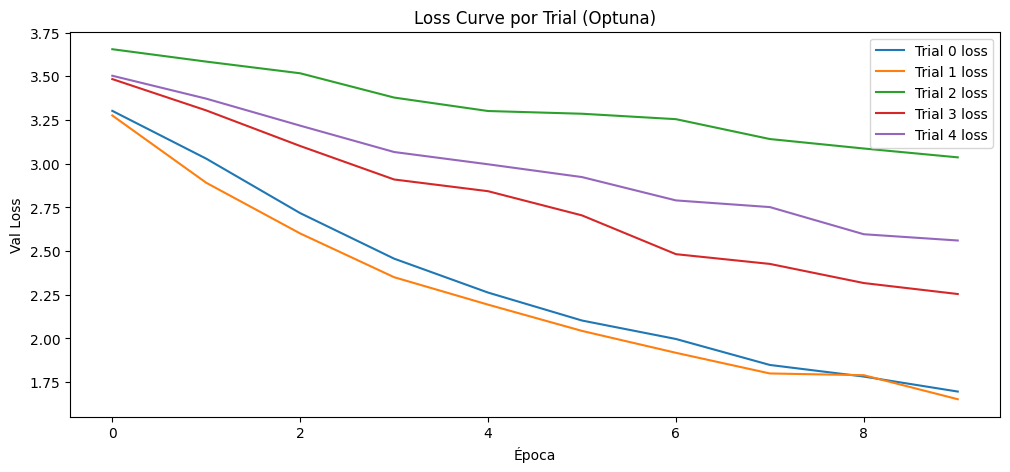

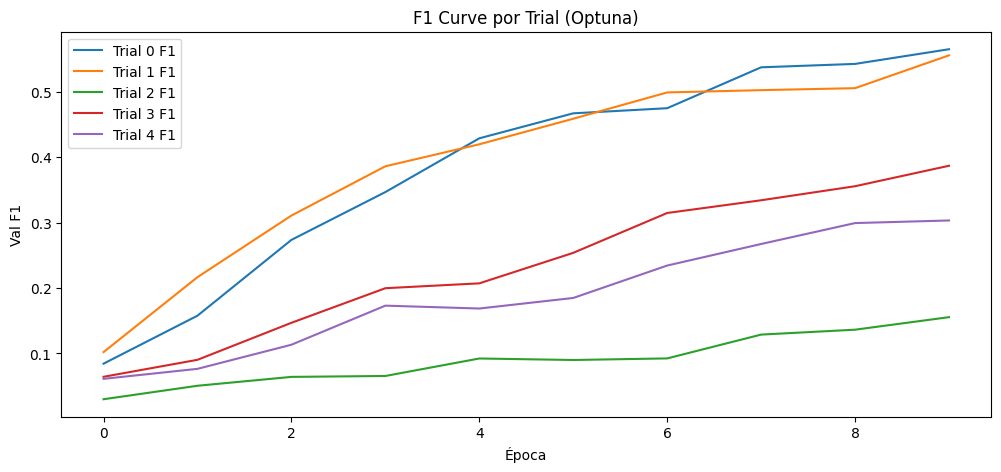

In [8]:
#split estratificado do train em train+val.
from sklearn.model_selection import StratifiedShuffleSplit

# separa validação estratificada a partir do train_dataset (recomendado)
labels = np.array([s[1] for s in train_dataset.samples])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))

# Subset samplers/datasets
from torch.utils.data import Subset
train_subset = Subset(train_dataset, train_idx)
val_subset   = Subset(train_dataset, val_idx)

train_loader_search = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_search   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Dicionário para guardar histórico de cada trial
trial_histories = {}

# --- função run_training atualizada ---
def run_training(model, train_loader, val_loader, device, lr=1e-4, weight_decay=1e-4, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_f1 = 0.0
    best_state = None

    # histórico
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_targets = evaluate(model, val_loader, criterion, device)
        val_f1 = f1_score(val_targets, val_preds, average='macro')

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_f1={val_f1:.4f}")
        scheduler.step(val_loss)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_f1, history


# --- função objetivo para Optuna ---
def objective(trial):
    model_name = trial.suggest_categorical("model_name", ["tf_efficientnet_b0", "tf_efficientnet_b3", "tf_efficientnet_b4"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    epochs = 10  # busca rápida

    # cria modelo pré-treinado
    model = create_model(model_name, num_classes=num_classes, pretrained=True).to(device)

    # --- congela todas as camadas, exceto o classificador ---
    for param in model.parameters():
        param.requires_grad = False
    for param in model.get_classifier().parameters():  # timm usa get_classifier()
        param.requires_grad = True

    # treina apenas o classificador
    model, best_val_f1, history = run_training(model, train_loader_search, val_loader_search, device, lr, weight_decay, epochs)

    trial_histories[trial.number] = history
    return best_val_f1


# --- Execução da busca de hiperparâmetros ---
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=5)  # aumente para resultados mais sólidos

print("Melhor trial:", study.best_trial.params, "Melhor F1:", study.best_value)


# --- Gráficos da busca de hiperparâmetros ---
plt.figure(figsize=(12,5))
for i, hist in trial_histories.items():
    plt.plot(hist['val_loss'], label=f'Trial {i} loss')
plt.title("Loss Curve por Trial (Optuna)")
plt.xlabel("Época")
plt.ylabel("Val Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for i, hist in trial_histories.items():
    plt.plot(hist['val_f1'], label=f'Trial {i} F1')
plt.title("F1 Curve por Trial (Optuna)")
plt.xlabel("Época")
plt.ylabel("Val F1")
plt.legend()
plt.show()


Epoch 1/30 | train_loss=3.5375 | val_loss=3.3574 | val_f1=0.0863


Epoch 2/30 | train_loss=3.1827 | val_loss=3.0721 | val_f1=0.1501


Epoch 3/30 | train_loss=2.9326 | val_loss=2.8080 | val_f1=0.2324


Epoch 4/30 | train_loss=2.6840 | val_loss=2.5945 | val_f1=0.3195


Epoch 5/30 | train_loss=2.4856 | val_loss=2.3913 | val_f1=0.3739


Epoch 6/30 | train_loss=2.3127 | val_loss=2.2240 | val_f1=0.4407


Epoch 7/30 | train_loss=2.1715 | val_loss=2.0795 | val_f1=0.4766


Epoch 8/30 | train_loss=2.0186 | val_loss=1.9388 | val_f1=0.5220


Epoch 9/30 | train_loss=1.9018 | val_loss=1.8459 | val_f1=0.5482


Epoch 10/30 | train_loss=1.8127 | val_loss=1.7360 | val_f1=0.5816


Epoch 11/30 | train_loss=1.7136 | val_loss=1.6519 | val_f1=0.6003


Epoch 12/30 | train_loss=1.6701 | val_loss=1.5613 | val_f1=0.6231


Epoch 13/30 | train_loss=1.5864 | val_loss=1.5423 | val_f1=0.6302


Epoch 14/30 | train_loss=1.5433 | val_loss=1.4643 | val_f1=0.6463


Epoch 15/30 | train_loss=1.4529 | val_loss=1.3839 | val_f1=0.6783


Epoch 16/30 | train_loss=1.4307 | val_loss=1.3313 | val_f1=0.6778


Epoch 17/30 | train_loss=1.3816 | val_loss=1.3132 | val_f1=0.6877


Epoch 18/30 | train_loss=1.3396 | val_loss=1.2688 | val_f1=0.6931


Epoch 19/30 | train_loss=1.3032 | val_loss=1.2123 | val_f1=0.7039


Epoch 20/30 | train_loss=1.2259 | val_loss=1.1926 | val_f1=0.7113


Epoch 21/30 | train_loss=1.2350 | val_loss=1.1708 | val_f1=0.7134


Epoch 22/30 | train_loss=1.2070 | val_loss=1.0965 | val_f1=0.7243


Epoch 23/30 | train_loss=1.1946 | val_loss=1.0795 | val_f1=0.7304


Epoch 24/30 | train_loss=1.1669 | val_loss=1.0667 | val_f1=0.7318


Epoch 25/30 | train_loss=1.1372 | val_loss=1.0539 | val_f1=0.7367


Epoch 26/30 | train_loss=1.0911 | val_loss=1.0276 | val_f1=0.7452


Epoch 27/30 | train_loss=1.0867 | val_loss=1.0058 | val_f1=0.7476


Epoch 28/30 | train_loss=1.0693 | val_loss=0.9766 | val_f1=0.7549


Epoch 29/30 | train_loss=1.0550 | val_loss=0.9950 | val_f1=0.7481


Epoch 30/30 | train_loss=1.0326 | val_loss=0.9533 | val_f1=0.7602
Melhor F1 (val) durante o treino final: 0.7602231717295993


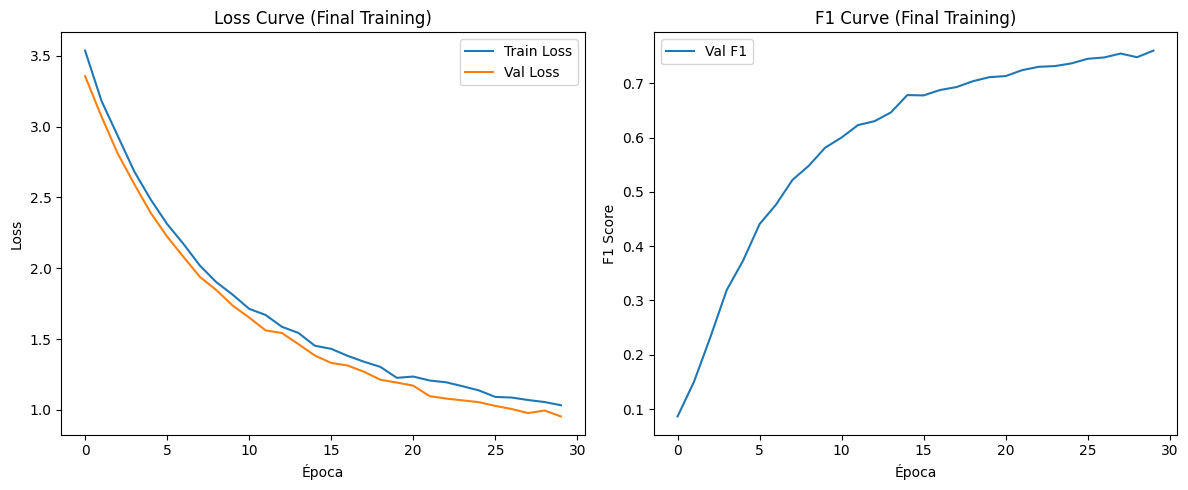

In [9]:
# Reutiliza best_params da busca (se existir). Cria modelo com in_chans=4 e treina final
best_params = globals().get("best_params", None)
if best_params is None:
    # se não existir best_params, defina manualmente:
    best_model_name = "tf_efficientnet_b3"
    best_lr = 1e-4
    best_wd = 1e-4
else:
    best_model_name = best_params.get("model_name", "tf_efficientnet_b3")
    best_lr = best_params.get("lr", 1e-4)
    best_wd = best_params.get("weight_decay", 1e-4)

final_model = create_model(best_model_name, num_classes=num_classes, pretrained=True, in_chans=4).to(device)
EPOCHS_FINAL = 30

# IMPORTANTE: run_training foi definido para treinar os parâmetros com requires_grad=True (o classificador).
final_model, best_val_f1, history = run_training(final_model, train_loader, test_loader, device, lr=best_lr, weight_decay=best_wd, epochs=EPOCHS_FINAL)
print("Melhor F1 (val) durante o treino final:", best_val_f1)

# --- Plots de histórico (se disponíveis) ---
if history is not None:
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(history['train_loss'], label='Train Loss')
    axs[0].plot(history['val_loss'], label='Val Loss')
    axs[0].set_title('Loss Curve (Final Training)')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history['val_f1'], label='Val F1')
    axs[1].set_title('F1 Curve (Final Training)')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('F1 Score')
    axs[1].legend()
    plt.tight_layout()
    plt.show()


Test loss: 0.9532792659600576
Test acc: 0.76375
Test F1 macro (com NGRDI): 0.7602231717295993
                   precision    recall  f1-score   support

          Airport     0.7361    0.6625    0.6974        80
         BareLand     0.9385    0.7625    0.8414        80
    BaseballField     0.9577    0.8500    0.9007        80
            Beach     0.8353    0.8875    0.8606        80
           Bridge     0.8276    0.6000    0.6957        80
           Center     0.7273    0.5000    0.5926        80
           Church     0.7639    0.6875    0.7237        80
       Commercial     0.5534    0.7125    0.6230        80
 DenseResidential     0.5600    0.8750    0.6829        80
           Desert     0.8111    0.9125    0.8588        80
         Farmland     0.9750    0.9750    0.9750        80
           Forest     0.9176    0.9750    0.9455        80
       Industrial     0.5400    0.6750    0.6000        80
           Meadow     0.9125    0.9125    0.9125        80
MediumResidential   

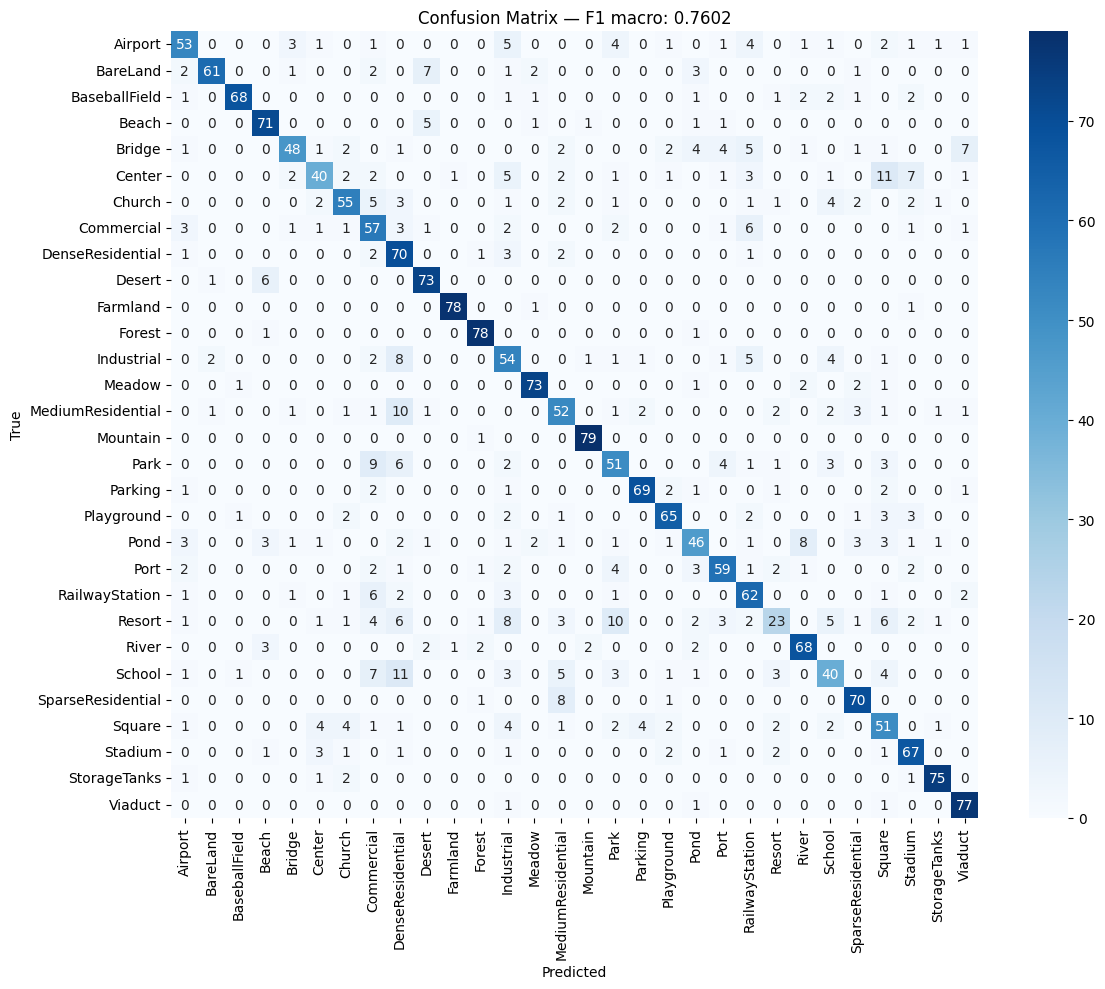

In [10]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, preds, targets = evaluate(final_model, test_loader, criterion, device)

macro_f1 = f1_score(targets, preds, average='macro')
print("Test loss:", test_loss)
print("Test acc:", test_acc)
print("Test F1 macro (com NGRDI):", macro_f1)

report = classification_report(targets, preds, target_names=test_dataset.classes, digits=4)
print(report)

cm = confusion_matrix(targets, preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # coloquei annot True para ver contagens
plt.title(f"Confusion Matrix — F1 macro: {macro_f1:.4f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(test_dataset.classes))+0.5, labels=test_dataset.classes, rotation=90)
plt.yticks(ticks=np.arange(len(test_dataset.classes))+0.5, labels=test_dataset.classes, rotation=0)
plt.tight_layout()
plt.show()
